## Extract data

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import gzip
import time
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import scipy
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import keras
from keras.callbacks import EarlyStopping
from keras.layers import Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

keras.backend.set_floatx('float64')
strikes_dim = 11
%matplotlib inline
os.chdir("data")

In [2]:
f = gzip.GzipFile('TrainrBergomiTermStructure.txt.gz', "r")
dat = np.load(f)
xx = dat[:,:11]
yy = dat[:,11:]
print(dat.shape, xx.shape, yy.shape)
strikes = np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5])
maturities = np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

(80000, 99) (80000, 11) (80000, 88)


In [3]:
NumParameters = xx.shape[1]

# Scale and Normalize data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(yy, xx, test_size=0.15, random_state=42)

scale = StandardScaler()
scale2 =  StandardScaler()
y_train_transform = scale.fit_transform(y_train)
y_test_transform = scale.transform(y_test)
x_train_transform = scale2.fit_transform(X_train)
x_test_transform = scale2.transform(X_test)

In [5]:
def xtransform(X_train,X_test):
    return [scale2.transform(X_train),scale2.transform(X_test)]

def xinversetransform(x):
    return scale2.inverse_transform(x.reshape(1, -1)).flatten()
    
[x_train_transform,x_test_transform] = xtransform(X_train, X_test)

In [6]:
# Upper and lower bounds used in the training set
ub = [0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16,   4,  0, 0.5]
lb = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.5, -1, 0.025]

def myscale(x):
    res = np.zeros(NumParameters)
    for i in range(NumParameters):
        res[i] = (x[i] - (ub[i] + lb[i]) * 0.5) * 2 / (ub[i] - lb[i])
        
    return res
def myinverse(x):
    res = np.zeros(NumParameters)
    for i in range(NumParameters):
        res[i] = x[i] * (ub[i] - lb[i]) * 0.5 + (ub[i] + lb[i]) * 0.5
        
    return res   

In [7]:
y_train_transform = np.array([myscale(y) for y in y_train])
y_test_transform = np.array([myscale(y) for y in y_test])

# Create the Neural Network

In [8]:
input1 = keras.layers.Input(shape=(NumParameters,))
x1 = keras.layers.Dense(30,activation = 'elu')(input1)
x2 = keras.layers.Dense(30,activation = 'elu')(x1) 
x3 = keras.layers.Dense(30,activation = 'elu')(x2) 
x4 = keras.layers.Dense(30,activation = 'elu')(x3)
x5 = keras.layers.Dense(88,activation = 'linear')(x4)

modelGEN = keras.models.Model(inputs=input1, outputs=x5)
modelGEN.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 88)             │         2,728 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,878 (45.92 KB)

 Trainable params: 5,878 (45.92 KB)

 Non-trainable params: 0 (0.00 B)

# Fit the Neural Network (No need to run the code, parameters are stored on a .h5 file)

In [9]:
patience = 25
NumEpochs = 500
earlystop = EarlyStopping(monitor="val_loss",
                          min_delta=0,
                          mode="min",
                          verbose=1, 
                          patience=patience)
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
modelGEN.compile(loss = root_mean_squared_error, optimizer = "adam")

modelGEN.fit(y_train_transform, x_train_transform, batch_size=32, validation_data = (y_test_transform,x_test_transform), epochs = NumEpochs, verbose = True, shuffle=1, callbacks=[earlystop])

Epoch 1/500
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 2s 487us/step - loss: 0.3382 - val_loss: 0.1070
Epoch 2/500
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 1s 456us/step - loss: 0.0979 - val_loss: 0.0819
Epoch 3/500
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 1s 451us/step - loss: 0.0777 - val_loss: 0.0697
Epoch 4/500
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 1s 451us/step - loss: 0.0683 - val_loss: 0.0634
Epoch 5/500
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 1s 447us/step - loss: 0.0620 - val_loss: 0.0610
Epoch 6/500
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 1s 446us/step - loss: 0.0580 - val_loss: 0.0544
Epoch 7/500
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 1s 455us/step - loss: 0.0549 - val_loss: 0.0537
Epoch 8/500
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 1s 447us/step - loss: 0.0523 - val_loss: 0.0491
Epoch 9/500
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 1s 452us/step - loss: 0.0503 - val_loss: 0.0495
Epoch 10/500
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 1s 451us/step - loss: 0.0491 - val_loss: 0.0498
Epoch 11/500
2125/2125 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 0.0477 - val_loss: 0.04

## Store optimal NN parameteres

In [12]:
NNParameters = []
for i in range(1,len(modelGEN.layers)):
    NNParameters.append(modelGEN.layers[i].get_weights())

# Hardcode the Neural Network in NUMPY for performance improvement

In [13]:
NumLayers = len(modelGEN.layers) - 2

def elu(x):
    # Careful, function overwrites x
    ind = (x<0)
    x[ind] = np.exp(x[ind])-1
    return x

def eluPrime(y):
    # we make a deep copy of input x
    x = np.copy(y)
    ind = (x<0)
    x[ind] = np.exp(x[ind])
    x[~ind] = 1
    return x

def NeuralNetwork(x):
    input1=x
    for i in range(NumLayers):
        input1 = np.dot(input1, NNParameters[i][0]) + NNParameters[i][1]
        #Elu activation
        input1 = elu(input1)
    #The output layer is linnear
    i+=1
    return np.dot(input1, NNParameters[i][0]) + NNParameters[i][1]

def NeuralNetworkGradient(x):
    input1 = x
    #Identity Matrix represents Jacobian with respect to initial parameters
    grad = np.eye(NumParameters)
    #Propagate the gradient via chain rule
    for i in range(NumLayers):
        input1 = (np.dot(input1, NNParameters[i][0]) + NNParameters[i][1])
        grad=(np.einsum('ij,jk->ik', grad, NNParameters[i][0]))
        #Elu activation
        grad*=eluPrime(input1)
        input1 = elu(input1)
    #input1.append(np.dot(input1[i],NNParameters[i+1][0])+NNParameters[i+1][1])
    grad=np.einsum('ij,jk->ik',grad,NNParameters[i+1][0])
    #grad stores all intermediate Jacobians, however only the last one is used here as output
    return grad
        

# Interactive plot, not working at the moment

In [14]:
# def plot_func(xi0,nu,rho,H):
#     x0=myscale(np.array([xi0,nu,rho,H]))
#     Smiles=xinversetransform(NeuralNetwork(x0))
#     plt.figure(1,figsize=(14,12))
#     for i in range(8):
#         plt.subplot(4,4,i+1)

        
#         plt.plot(np.log(strikes/1),Smiles[i*strikes_dim:(i+1)*strikes_dim],'*b',label=" NN Approx")

#         plt.ylim(0.1,0.8)
#         plt.title("Maturity=%1.2f "%maturities[i])
#         plt.xlabel("log-moneyness")
#         plt.ylabel("Implied vol")

#         plt.legend()
#     plt.tight_layout()
# ub=0.16,4,-0.1,0.5
# lb=[0.01,0.3,-0.95,0.025]
# interact(plot_func, xi0 = widgets.FloatSlider(value=0.04,
#                                                min=0.01,
#                                                max=0.16,
#                                                step=0.01),
#         nu = widgets.FloatSlider(value=2,
#                                                min=0.3,
#                                                max=4.0,
#                                                step=0.1),
#         rho = widgets.FloatSlider(value=-0.7,
#                                                min=-0.95,
#                                                max=-0.1,
#                                                step=0.05),
#         H = widgets.FloatSlider(value=0.1,
#                                                min=0.025,
#                                                max=0.5,
#                                                step=0.05))

# Numpy gives roughly 15 fold speed improvement

In [15]:
%timeit NeuralNetwork(y_test_transform[0])

13.5 μs ± 109 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [16]:
%timeit modelGEN.predict(y_test_transform[0].reshape(1,NumParameters))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━

# Compute Implied vol relative errors on Test set

In [17]:
S0 = 1.
strikes_dim = len(strikes)
maturities_dim = len(maturities)
strikeslabel = np.round(np.linspace(strikes[0], strikes[-1], 8), 1)
maturitieslabel = np.array([0.1, 0.2, 0.6, 1.5, 1.8])

##### AVERAGE VALUES #######
X_sample = X_test
y_sample = y_test_transform

prediction = [xinversetransform(NeuralNetwork(y_sample[i])) for i in range(len(y_sample))]

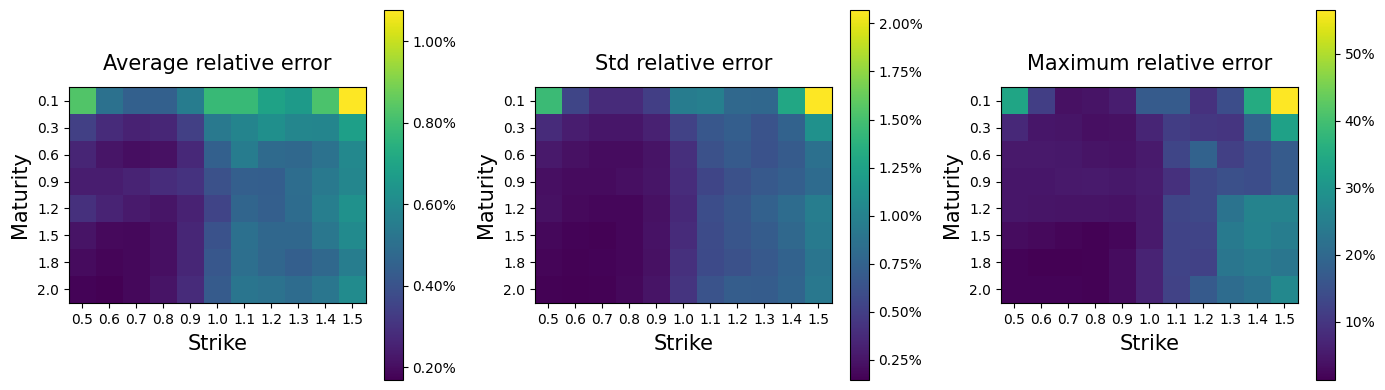

In [18]:
plt.figure(1,figsize=(14,4))
ax = plt.subplot(1,3,1)
err = np.mean(100 * np.abs((X_sample - prediction) / X_sample), axis = 0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0,len(strikes) - 1, len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities) - 1, len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike", fontsize=15, labelpad=5)
plt.ylabel("Maturity", fontsize=15, labelpad=5)

ax = plt.subplot(1,3,2)
err = 100 * np.std(np.abs((X_sample-prediction) / X_sample), axis = 0)
plt.title("Std relative error", fontsize=15, y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes) - 1, len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities) - 1, len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike", fontsize=15, labelpad=5)
plt.ylabel("Maturity", fontsize=15, labelpad=5)

ax = plt.subplot(1,3,3)
err = 100*np.max(np.abs((X_sample-prediction) / X_sample), axis = 0)
plt.title("Maximum relative error", fontsize=15, y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes) - 1, len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities) - 1, len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike", fontsize=15, labelpad=5)
plt.ylabel("Maturity", fontsize=15, labelpad=5)
plt.tight_layout()
plt.savefig('rBergomiTermStructureNNErrors.PNG', dpi=300)
plt.show()

# Plot sample Smiles

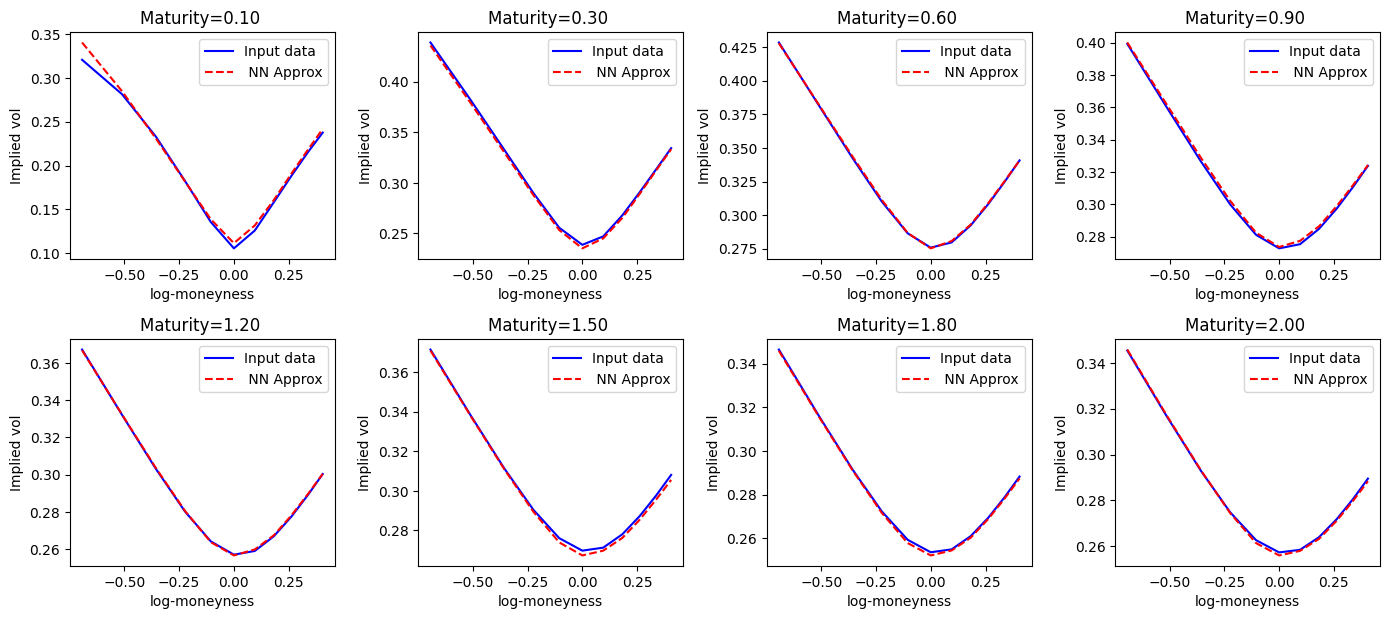

Model Parameters:  [ 0.0120208  0.0992092  0.126305   0.0995428  0.0581061  0.157695
  0.0340984  0.137483   1.63103   -0.060068   0.227925 ]


In [19]:
S0=1.

sample_ind = 250
X_sample = X_test[sample_ind]
y_sample = y_test_transform[sample_ind]
prediction = xinversetransform(NeuralNetwork(y_sample))

plt.figure(1,figsize=(14,12))
for i in range(maturities_dim):
    plt.subplot(4,4,i+1)
    
    plt.plot(np.log(strikes/S0),X_sample[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
    plt.plot(np.log(strikes/S0),prediction[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")

    
    plt.title("Maturity=%1.2f "%maturities[i])
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied vol")
    
    plt.legend()
plt.tight_layout()
plt.show()

print("Model Parameters: ", myinverse(y_sample))

# Use gradient methods for optimization

In [20]:
def CostFunc(x,sample_ind):
    return np.sum(np.power((NeuralNetwork(x) - x_test_transform[sample_ind]), 2))
def Jacobian(x,sample_ind):
    return 2*np.sum((NeuralNetwork(x) - x_test_transform[sample_ind]) * NeuralNetworkGradient(x), axis=1)
#Cost Function for Levenberg Marquardt
def CostFuncLS(x,sample_ind):
    return (NeuralNetwork(x) - x_test_transform[sample_ind])
def JacobianLS(x,sample_ind):
    return NeuralNetworkGradient(x).T

In [21]:
CalibratedParameters = []
Timing = []
solutions = np.zeros([4,NumParameters])
times = np.zeros(4)
init = np.zeros(NumParameters)

for i in range(5000):
    disp = str(i+1)+"/5000"
    print(disp,end="\r")
    #L-BFGS-B
    start = time.perf_counter()
    I = scipy.optimize.minimize(CostFunc, x0=init, args=i, method='L-BFGS-B', jac=Jacobian, tol=1E-10, options={"maxiter":5000})
    end = time.perf_counter()
    solutions[0,:] = myinverse(I.x)
    times[0] = end - start
    #SLSQP
    start = time.perf_counter()
    I = scipy.optimize.minimize(CostFunc, x0=init, args=i, method='SLSQP', jac=Jacobian, tol=1E-10, options={"maxiter":5000})
    end = time.perf_counter()
    solutions[1,:] = myinverse(I.x)
    times[1] = end - start
    #BFGS
    start = time.perf_counter()
    I = scipy.optimize.minimize(CostFunc, x0=init, args=i, method='BFGS', jac=Jacobian, tol=1E-10, options={"maxiter":5000})
    end = time.perf_counter()
    solutions[2,:] = myinverse(I.x)
    times[2] = end - start
    #Levenberg-Marquardt
    start = time.perf_counter()
    I = scipy.optimize.least_squares(CostFuncLS, init, JacobianLS, args=(i,), gtol=1E-10)
    end = time.perf_counter()
    solutions[3,:] = myinverse(I.x)
    times[3] = end - start
    
    CalibratedParameters.append(np.copy(solutions))
    Timing.append(np.copy(times))    

# Plot calibration times

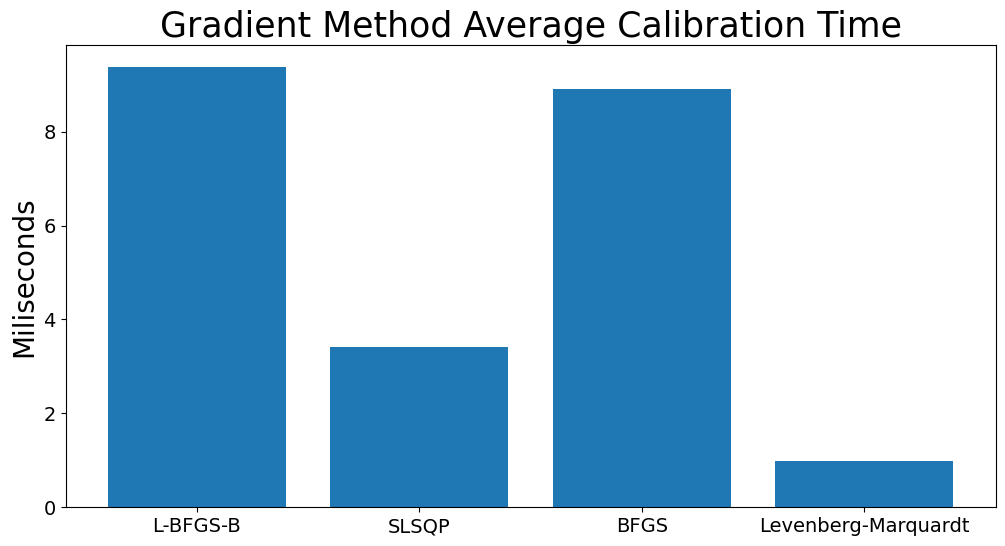

In [22]:
methods = ["L-BFGS-B", "SLSQP", "BFGS", "Levenberg-Marquardt"]
plt.figure(1, figsize=(12,6))
plt.bar(methods, np.mean(Timing,axis=0) * 1000)
#plt.legend(methods)
plt.title("Gradient Method Average Calibration Time", fontsize=25)
plt.ylabel("Miliseconds", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

# Plot relative errors for levenberg-Marquardt optimal parameters

average =  0.012520946446763577
average =  0.014315482218954281
average =  0.01807638073545084
average =  0.04626061879402461
average =  0.050117190890217864
average =  0.05633173688671506
average =  0.07748693787408038
average =  0.15962254466763323
average =  0.007925823603762084
average =  0.04580793219698544
average =  0.02294157700531218


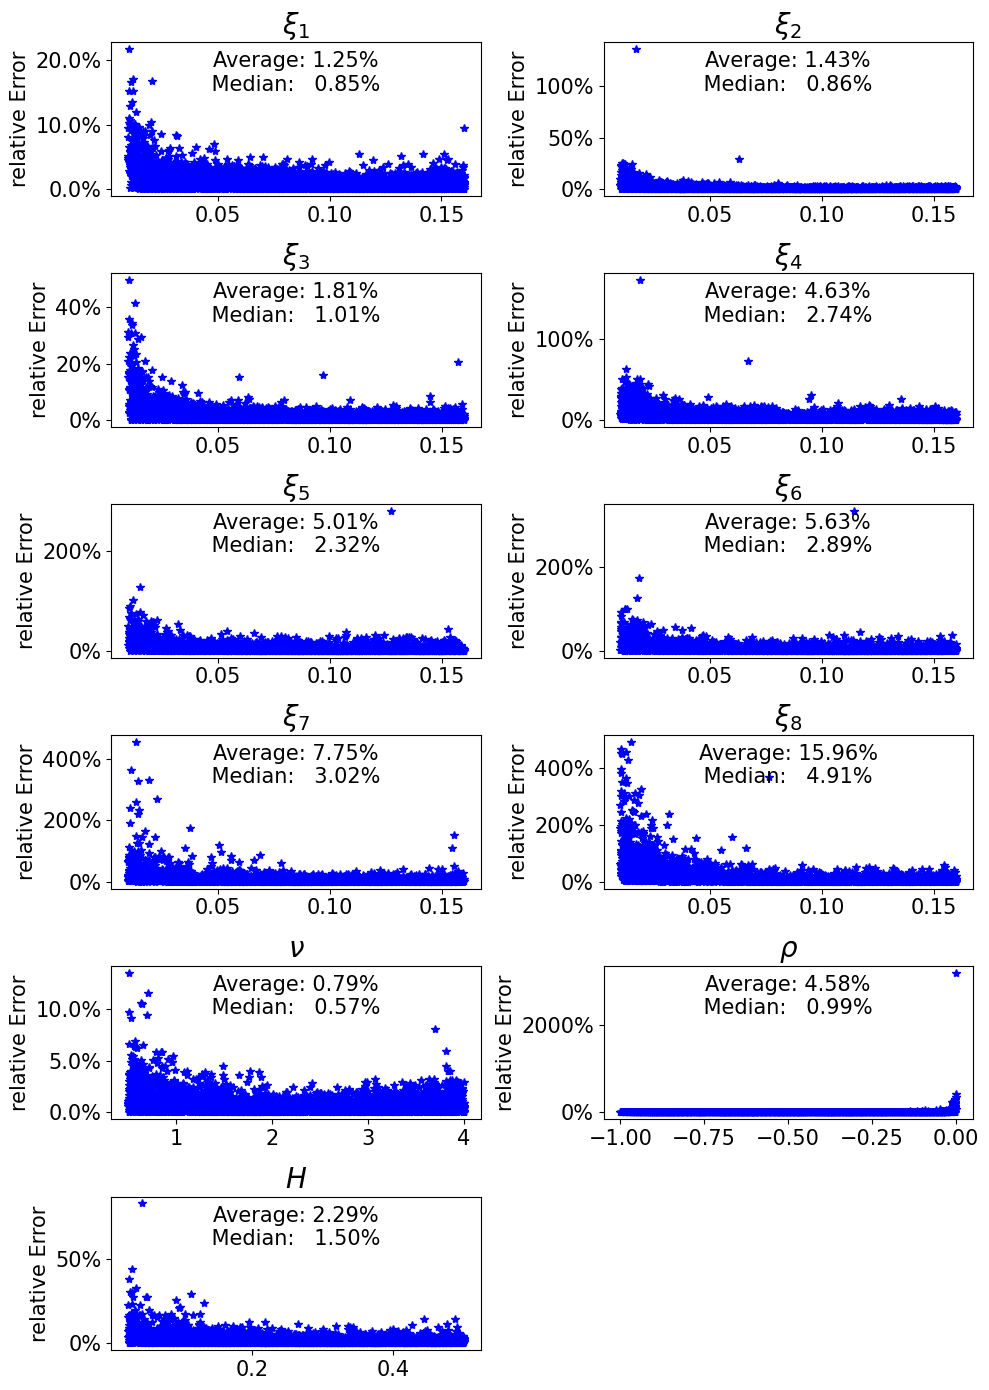

In [23]:
titles = ["$\\xi_1$","$\\xi_2$","$\\xi_3$","$\\xi_4$","$\\xi_5$","$\\xi_6$","$\\xi_7$","$\\xi_8$","$\\nu$","$\\rho$","$H$"]
average = np.zeros([11,5000])
fig = plt.figure(figsize=(10,14))
for u in range(11):
    ax=plt.subplot(6,2,u+1)
    for i in range(5000):
        
        y = y_test[i][u]
        plt.plot(y, 100*np.abs(CalibratedParameters[i][3][u] - y) / np.abs(y), 'b*')
        average[u,i] = np.abs(CalibratedParameters[i][3][u] - y) / np.abs(y)
    plt.title(titles[u], fontsize=20)
    plt.ylabel('relative Error', fontsize=15)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.text(0.5, 0.8, 'Average: %1.2f%%\n Median:   %1.2f%% '%(np.mean(100*average[u,:]),np.quantile(100*average[u,:],0.5)), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)

    print("average = ",np.mean(average[u,:]))
plt.tight_layout()
plt.savefig('rBergomiTermStructureParameterRelativeErrors.png', dpi=300)
plt.show()

In [24]:
LMParameters = [CalibratedParameters[i][3] for i in range(len(CalibratedParameters))]
np.savetxt("NNParametersrBergomiTermStructure.txt", LMParameters)  

In [25]:
Parameters = np.loadtxt("NNParametersr1FactorTermStructure.txt")

# Compare calibrated surfaces to original ones

In [27]:
# Load surfaces generated using optimal parameters
SurfacesCalib = np.loadtxt("surfacesFromNNRoughBergomiTermStructure.txt")
SurfacesCalib = SurfacesCalib[:,11:]
SurfacesTarget = X_test[:5000]
#We drop indices that don't give implied vols due to MC error
RMSENN = np.sqrt(np.mean(np.power(SurfacesCalib-SurfacesTarget, 2), axis=1))
ind = ~(RMSENN==np.inf)
RMSENN = RMSENN[ind]
len(RMSENN)

C:\Users\ole\AppData\Local\Temp\ipykernel_24012\911152018.py:6: RuntimeWarning: overflow encountered in power
  RMSENN = np.sqrt(np.mean(np.power(SurfacesCalib-SurfacesTarget, 2), axis=1))


4941

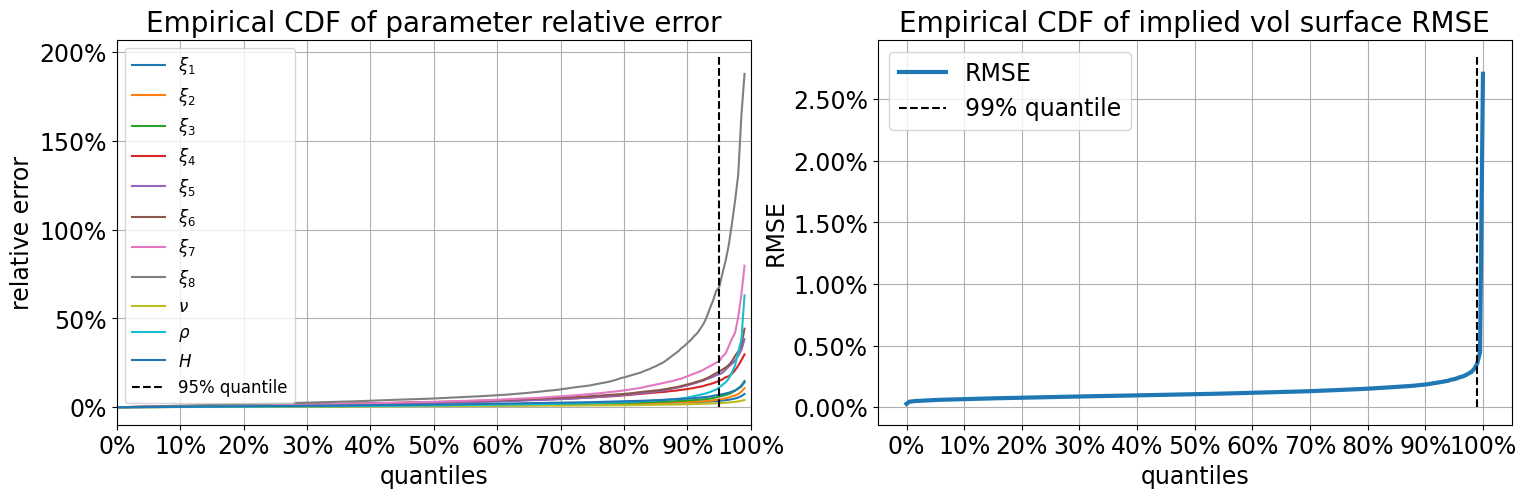

In [28]:
plt.figure(figsize=(18, 5))
plt.clf()
plt.subplot(121)

ax = plt.gca()
q=np.linspace(0,0.99,200)
for u in range(11):
    p=plt.plot(100*q,np.quantile(100*average[u,:],q),label=titles[u])    
    c=p[0].get_color()
ymin, ymax = ax.get_ylim()
ax.set_xlim(0,100)
plt.plot(100*np.ones(2)*0.95,np.array([0,ymax]),'--k',label="95% quantile")
plt.title("Empirical CDF of parameter relative error",fontsize=20)
plt.legend(fontsize=12)
plt.xlabel("quantiles",fontsize=17)
plt.ylabel("relative error",fontsize=17)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter() )
plt.tick_params(axis='both', which='major', labelsize=17)
plt.tick_params(axis='both', which='minor', labelsize=17)
plt.xticks(np.arange(0, 101, step=10))

plt.grid()
plt.subplot(122)


ax = plt.gca()
q=np.linspace(0,1,200)
p=plt.plot(100*q,np.quantile(100*RMSENN,q),linewidth=3,label="RMSE")
ymin, ymax = ax.get_ylim()
plt.plot(100*np.ones(2)*0.99,np.array([0,ymax]),'--k',label="99% quantile")
plt.title("Empirical CDF of implied vol surface RMSE",fontsize=20)
plt.legend(fontsize=17)
plt.xlabel("quantiles",fontsize=17)
plt.ylabel("RMSE",fontsize=17)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter() )
plt.tick_params(axis='both', which='major', labelsize=17)
plt.tick_params(axis='both', which='minor', labelsize=17)
plt.xticks(np.arange(0, 101, step=10))
plt.grid()
plt.savefig('rBergomiTermStructureErrorCDF.png', dpi=300)
plt.show()